<a href="https://colab.research.google.com/github/FurcyPin/french-gas-price/blob/main/Data_diff_spark_carburant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Run this to setup the environment**



In [83]:
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-11-openjdk-amd64/jre/bin/java
!pip install pyspark==3.5.1
!pip install spark-frame=="0.5.*"
!pip install data-diff-viewer=="0.3.*"

update-alternatives: error: alternative /usr/lib/jvm/java-11-openjdk-amd64/jre/bin/java for java not registered; not setting


In [84]:
import os
import sys
import datetime

from pyspark.sql import SparkSession, Column
from pyspark.sql import functions as f

from java_dependency import JavaDependency

day = datetime.date.today().isoformat()

os.environ["PYSPARK_PYTHON"] = sys.executable

spark_xml = JavaDependency(
    group_id="com.databricks",
    artifact_id="spark-xml_2.12",
    version="0.17.0",
)
spark_xml.download()

spark = (SparkSession.builder
         .appName("french-gas-prices")
         .config("spark.driver.extraClassPath", str(spark_xml.jar_path))
         .config("spark.sql.parquet.int96RebaseModeInWrite", "CORRECTED")
         .config("spark.sql.session.timeZone", "UTC")
         .getOrCreate())

Getting jars/spark-xml_2.12-0.17.0.jar: already downloaded


In [85]:
import download_data

# Phase 1: Loading the two dataframes and first comparison.


## Step 1.1: Loading the v1 data (XML file --> Spark DataFrame)

In [86]:
from spark_frame.schema_utils import schema_from_json
from v1_schema import v1_schema

xml_options = {
    "rootTag": "pdv_list",
    "rowTag": "pdv",
    "charset": "ISO-8859-1",
    "mode": "FAILFAST"
}

df_v1_xml_raw = (
  spark.read.format("xml")
  .schema(schema_from_json(v1_schema))
  .options(**xml_options)
  .load(f"data/v1_xml/day={day}/PrixCarburants_instantane_ruptures.xml")
)

## [Parenthesis] Introducing a feature : schema_from_json

In this part of the code, we used [`spark_frame.schema_utils.schema_from_json`](https://furcypin.github.io/spark-frame/reference/schema_utils/#spark_frame.schema_utils.schema_from_json) which is a simple function to convert a json string representing a Spark DataFrame schema into a StructType object that can be used to enforce the schema of a data source.

The json representing the full schema being quite large, we did not write it manually but instead used Spark's schema autodetection feature for xml sources, and then wrote the json schema using the method [`spark_frame.schema_utils.schema_to_pretty_json`](https://furcypin.github.io/spark-frame/reference/schema_utils/#spark_frame.schema_utils.schema_to_pretty_json), and then we manually edited the few types that were not inferred correctly by Spark.


In [87]:
df_v1_xml_raw.toPandas()

,_cp,_id,_latitude,_longitude,_pop,adresse,horaires,prix,rupture,services,ville
0,83590,83590001,4.331600e+06,627500.000000,R,"Le Murier, RD 97","(1, [(None, , 1, Lundi, [Row(_VALUE=None, _fer...","[(None, 1, 2024-04-24 09:42:23, Gazole, 1.739)...","[(None, 2021-11-05 07:55:41, , 2, SP95, defini...","([Laverie, Station de gonflage, Lavage automat...",Gonfaron
1,63230,63230001,4.584100e+06,275900.000000,R,6 AVENUE DES VOLCANS - D941,"(1, [(None, , 1, Lundi, [Row(_VALUE=None, _fer...","[(None, 1, 2024-04-30 05:49:39, Gazole, 1.813)...","[(None, 2022-09-15 06:07:13, , 2, SP95, tempor...","([Toilettes publiques, Boutique alimentaire, R...",LA GOUTELLE
2,44200,44000009,4.720393e+06,-154657.000000,R,16 BD DES MARTYRS NANTAIS,None,"[(None, 1, 2024-05-01 00:01:00, Gazole, 1.803)...","[(None, 2022-09-12 13:59:19, , 2, SP95, defini...","([Toilettes publiques, Boutique alimentaire, B...",NANTES
3,92230,92230008,4.893270e+06,230440.000000,R,192 Avenue Louis Roche,None,"[(None, 1, 2024-04-19 14:19:00, Gazole, 1.839)...","[(None, 2018-11-02 12:13:02, , 3, E85, definit...","(None,)",GENNEVILLIERS
4,13760,13750006,4.361756e+06,530776.150947,R,Espace Daumas,"(1, [(None, 1, 1, Lundi, [Row(_VALUE=None, _fe...","[(None, 1, 2024-04-27 05:52:15, Gazole, 1.711)...","[(None, 2019-06-14 05:42:35, , 2, SP95, defini...","([Automate CB 24/24],)",Saint-Cannat
...,...,...,...,...,...,...,...,...,...,...,...
9988,70200,70200006,4.767500e+06,652100.000000,R,16 Rue de Belfort,"(1, [(None, , 1, Lundi, [Row(_VALUE=None, _fer...","[(None, 1, 2024-04-27 00:01:00, Gazole, 1.804)...","[(None, 2012-12-17 16:50:00, , 3, E85, ), (Non...","([Toilettes publiques, Boutique alimentaire, B...",LURE
9989,32310,32310004,4.386900e+06,39200.000000,R,"Route D'Auche, Lieu Dit Haut Rege","(, [(None, , 1, Lundi, None), (None, , 2, Mard...","[(None, 1, 2024-04-30 10:19:44, Gazole, 1.755)...","[(None, 2018-03-19 11:17:49, , 3, E85, definit...","(None,)",Valence-sur-Baïse
9990,79200,79200006,4.664100e+06,-26200.000000,R,20 Boulevard Georges Clemenceau,"(1, [(None, , 1, Lundi, [Row(_VALUE=None, _fer...","[(None, 1, 2024-05-01 06:19:18, Gazole, 1.862)...","[(None, 2017-08-30 22:20:35, , 2, SP95, defini...","([Toilettes publiques, Laverie, Relais colis, ...",PARTHENAY
9991,17100,17100005,4.574600e+06,-67400.000000,R,15 Rue Champagne Saint Georges,"(1, [(None, , 1, Lundi, None), (None, , 2, Mar...","[(None, 1, 2024-04-24 09:27:35, Gazole, 1.689)...","[(None, 2019-11-02 12:09:56, , 4, GPLc, defini...","([Toilettes publiques, Boutique alimentaire, B...",Saintes


In [88]:
df_v1_xml_raw.printSchema()

root
 |-- _cp: string (nullable = true)
 |-- _id: long (nullable = true)
 |-- _latitude: double (nullable = true)
 |-- _longitude: double (nullable = true)
 |-- _pop: string (nullable = true)
 |-- adresse: string (nullable = true)
 |-- horaires: struct (nullable = true)
 |    |-- _automate-24-24: string (nullable = true)
 |    |-- jour: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- _VALUE: string (nullable = true)
 |    |    |    |-- _ferme: string (nullable = true)
 |    |    |    |-- _id: long (nullable = true)
 |    |    |    |-- _nom: string (nullable = true)
 |    |    |    |-- horaire: array (nullable = true)
 |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    |-- _VALUE: string (nullable = true)
 |    |    |    |    |    |-- _fermeture: double (nullable = true)
 |    |    |    |    |    |-- _ouverture: double (nullable = true)
 |-- prix: array (nullable = true)
 |    |-- element: struct (cont

## Step 1.2: Loading the v2 data (JSON file -> Spark DataFrame)

In [89]:
json_options = {
    "encoding": "ISO-8859-1",
}
df_v2_json_raw = spark.read.format("json").load(f"data/v2_json/day={day}/data.json")

In [90]:
df_v2_json_raw.printSchema()

root
 |-- adresse: string (nullable = true)
 |-- carburants_disponibles: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- carburants_indisponibles: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- carburants_rupture_definitive: string (nullable = true)
 |-- carburants_rupture_temporaire: string (nullable = true)
 |-- code_departement: string (nullable = true)
 |-- code_region: string (nullable = true)
 |-- cp: string (nullable = true)
 |-- departement: string (nullable = true)
 |-- e10_maj: string (nullable = true)
 |-- e10_prix: double (nullable = true)
 |-- e10_rupture_debut: string (nullable = true)
 |-- e10_rupture_type: string (nullable = true)
 |-- e85_maj: string (nullable = true)
 |-- e85_prix: double (nullable = true)
 |-- e85_rupture_debut: string (nullable = true)
 |-- e85_rupture_type: string (nullable = true)
 |-- gazole_maj: string (nullable = true)
 |-- gazole_prix: double (nullable = true)
 |-- gazole_rupture_debut

In [91]:
df_v2_json_raw.toPandas()

,adresse,carburants_disponibles,carburants_indisponibles,carburants_rupture_definitive,carburants_rupture_temporaire,code_departement,code_region,cp,departement,e10_maj,...,services_service,sp95_maj,sp95_prix,sp95_rupture_debut,sp95_rupture_type,sp98_maj,sp98_prix,sp98_rupture_debut,sp98_rupture_type,ville
0,20 avenue robert schumann,"[Gazole, SP95, E10, SP98]","[E85, GPLc]",E85,None,95,11,95350,Val-d'Oise,2024-05-01T00:41:00+02:00,...,"[Vente de gaz domestique (Butane, Propane), DA...",2024-04-29T16:51:00+02:00,1.935,None,None,2024-05-01T00:41:00+02:00,1.998,None,None,Saint-Brice-sous-Forêt
1,Avenue Georges Pompidou,"[Gazole, E85, E10, SP98]","[SP95, GPLc]",None,None,13,93,13270,Bouches-du-Rhône,2024-04-30T11:43:03+02:00,...,"[Vente de fioul domestique, Lavage manuel, Ven...",None,NaN,None,None,2024-04-30T11:43:03+02:00,1.999,None,None,Fos-sur-Mer
2,BOULEVARD DE LA FLECHE,"[Gazole, SP95, E85, SP98]","[GPLc, E10]",GPLc;E10,None,14,28,14220,Calvados,None,...,"[Toilettes publiques, Laverie, Relais colis, B...",2024-04-15T14:43:07+02:00,1.999,None,None,2024-04-15T14:43:16+02:00,2.049,None,None,Thury-Harcourt-le-Hom
3,DEVIATION RN 568 OUEST,"[Gazole, E10, SP98]","[SP95, E85, GPLc]",None,None,13,93,13270,Bouches-du-Rhône,2024-04-27T10:01:00+02:00,...,None,None,NaN,None,None,2024-04-27T10:01:00+02:00,1.962,None,None,Fos-sur-Mer
4,87 rue jean monet,"[Gazole, SP95, SP98]","[E85, GPLc, E10]",E85;GPLc;E10,None,87,75,87570,Haute-Vienne,None,...,"[Restauration à emporter, Station de gonflage,...",2024-04-20T07:30:02+02:00,1.979,None,None,2024-03-31T08:24:23+02:00,1.999,None,None,Rilhac-Rancon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9988,1005 AV. CHARLES DE GAULLE,"[Gazole, E10, SP98]","[SP95, E85, GPLc]",GPLc,None,26,84,26300,Drôme,2024-04-26T12:03:12+02:00,...,"[Boutique alimentaire, Boutique non alimentair...",None,NaN,None,None,2024-04-26T12:03:12+02:00,1.990,None,None,Chatuzange-le-Goubet
9989,34 RUE HENRI BERGER,"[Gazole, E85, E10, SP98]","[SP95, GPLc]",SP95;GPLc,None,21,27,21610,Côte-d'Or,2024-04-30T08:36:34+02:00,...,"[Laverie, Station de gonflage, Piste poids lou...",None,NaN,2022-03-01T11:42:24+01:00,definitive,2024-04-30T08:36:53+02:00,1.959,None,None,Fontaine-Française
9990,rue de la grande bruyère,"[Gazole, SP95, E10, SP98]","[E85, GPLc]",E85;GPLc,None,71,27,71600,Saône-et-Loire,2024-04-20T21:15:00+02:00,...,[Automate CB 24/24],2024-04-20T21:15:00+02:00,1.929,None,None,2024-04-25T21:55:45+02:00,1.979,None,None,Paray-le-Monial
9991,165 route de Meurchin,"[Gazole, E85, E10, SP98]","[SP95, GPLc]",SP95;GPLc,None,62,32,62220,Pas-de-Calais,2024-04-27T09:00:00+02:00,...,"[Relais colis, Boutique alimentaire, Boutique ...",None,NaN,2022-04-04T12:15:29+02:00,definitive,2024-04-13T09:00:00+02:00,1.969,None,None,Carvin


## Step 1.3. First comparison between DataFrames

In [92]:
from spark_frame.data_diff import DiffFormatOptions, compare_dataframes

diff_result = compare_dataframes(df_v1_xml_raw.withColumnRenamed("_id", "id"), df_v2_json_raw, join_cols=["id"])
# diff_result.diff_df_shards[""].printSchema()
diff_format_options = DiffFormatOptions(
    nb_top_values_kept_per_column=200,
    left_df_alias="df_v1_xml",
    right_df_alias="df_v2_json",
)

diff_result.export_to_html(
    title="Comparaison des sources brutes: v1 vs v2",
    diff_format_options=diff_format_options,
    output_file_path="diff_raw.html"
)


Analyzing differences...
Generating the diff by joining the DataFrames together using the provided column: id
Report exported as diff_raw.html


This will generate a `diff_raw.html` that we can download and open in a browser.
As we can see, the results aren't great looking because we have a lot of differences between the dataframes.

Once generated, the file can be downloaded from the right panel of this notebook in the "file section".

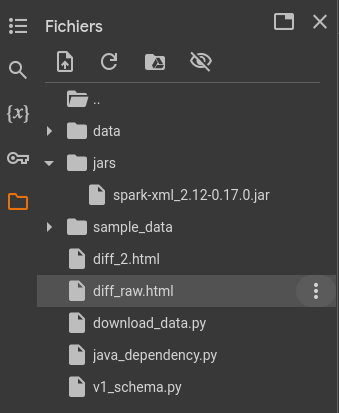

After downloading it, open on it and it will open in your favorite browser. You should see something that looks like this:

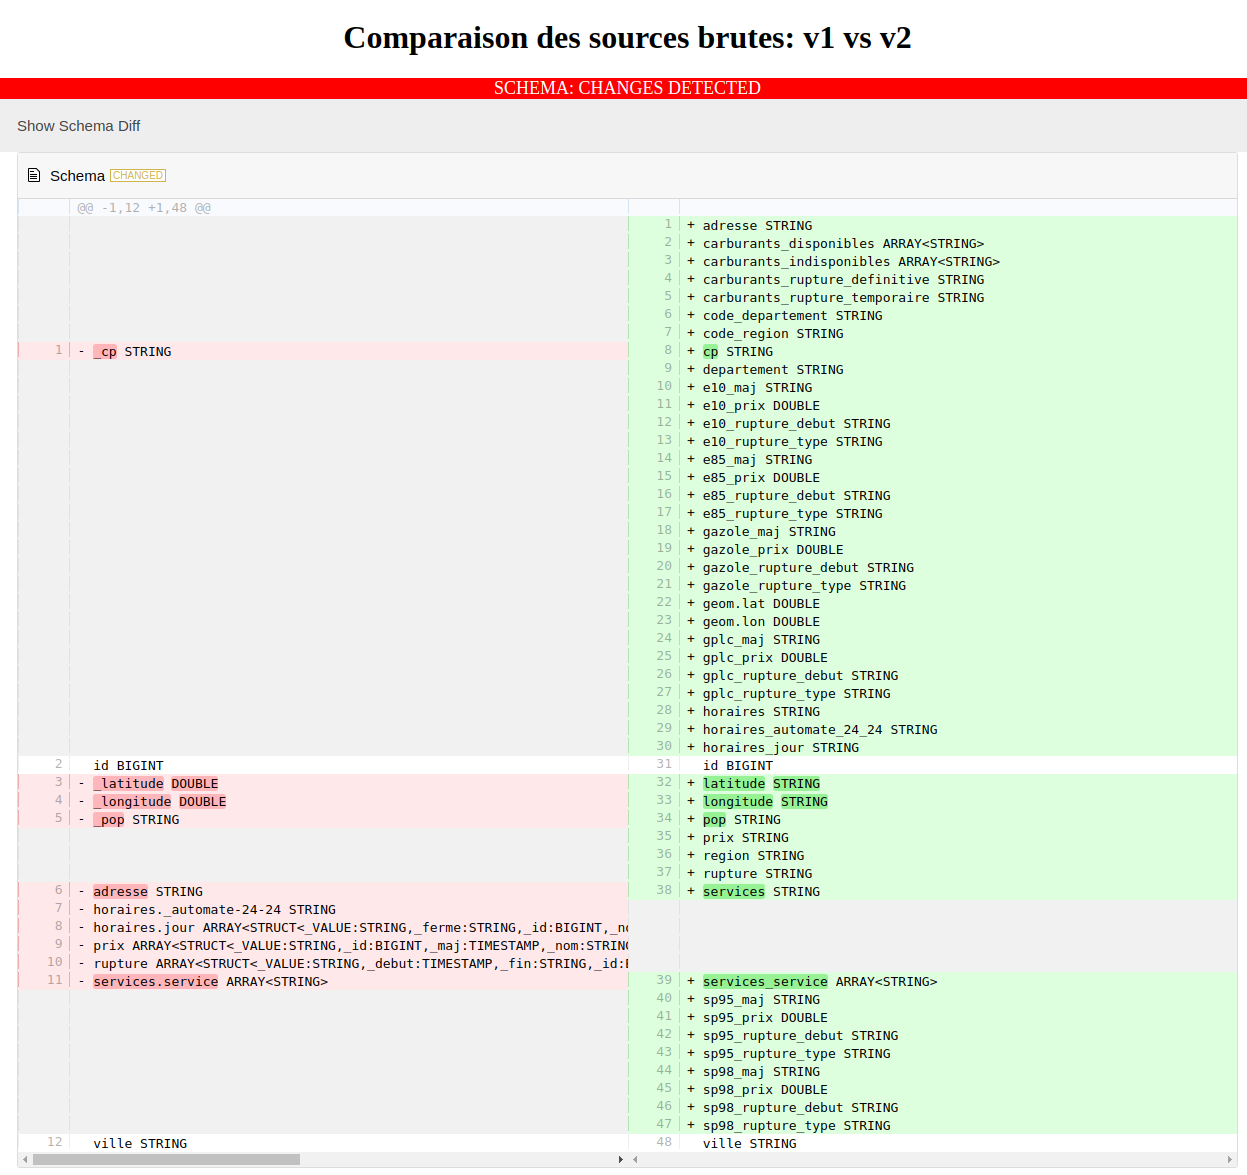

As we can see, there isn't many columns that match both sides at the moment.
But we will walk through this to make the two DataFrames more comparable, which will also let us showcase some nice spark-frame features.

# Phase 2: Renaming columns to make them match

First we notice in the diffs that some columns have very similar names, like `_latitude` in v1 and `latitude` in v2. So we will use the method `transform_all_field_names` to remove the underscore prefix from every field names in the v1 DataFrame, like this:

In [93]:
from spark_frame.transformations import transform_all_field_names

def clean_field_names(name: str):
    name = name.lower()
    if name.startswith("_"):
        return name[1:]
    else:
        return name

df_v1_xml_2 = df_v1_xml_raw.transform(transform_all_field_names, clean_field_names)
# Which is equivalent to:
# df_v1_xml_2 = transform_all_field_names(df_v1_xml_raw, clean_field_names)

In [94]:
df_v1_xml_2.printSchema()

root
 |-- cp: string (nullable = true)
 |-- id: long (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- pop: string (nullable = true)
 |-- adresse: string (nullable = true)
 |-- horaires: struct (nullable = false)
 |    |-- automate-24-24: string (nullable = true)
 |    |-- jour: array (nullable = true)
 |    |    |-- element: struct (containsNull = false)
 |    |    |    |-- value: string (nullable = true)
 |    |    |    |-- ferme: string (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- nom: string (nullable = true)
 |    |    |    |-- horaire: array (nullable = true)
 |    |    |    |    |-- element: struct (containsNull = false)
 |    |    |    |    |    |-- value: string (nullable = true)
 |    |    |    |    |    |-- fermeture: double (nullable = true)
 |    |    |    |    |    |-- ouverture: double (nullable = true)
 |-- prix: array (nullable = true)
 |    |-- element: struct (containsNull =

## [Parenthesis] Just for fun

Just for fun, let's try to translate all the field names in English:


In [95]:
!pip install translators==5.9.1 > /dev/null
import translators as ts

df_v2_xml_en = df_v1_xml_2.transform(transform_all_field_names, lambda col: ts.translate_text(col, "google", "fr", "en"))
df_v2_xml_en.printSchema()


root
 |-- CP: string (nullable = true)
 |-- id: long (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- pop: string (nullable = true)
 |-- address: string (nullable = true)
 |-- schedules: struct (nullable = false)
 |    |-- PLC-24-24: string (nullable = true)
 |    |-- day: array (nullable = true)
 |    |    |-- element: struct (containsNull = false)
 |    |    |    |-- value: string (nullable = true)
 |    |    |    |-- farm: string (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- name: string (nullable = true)
 |    |    |    |-- hourly: array (nullable = true)
 |    |    |    |    |-- element: struct (containsNull = false)
 |    |    |    |    |    |-- value: string (nullable = true)
 |    |    |    |    |    |-- closing: double (nullable = true)
 |    |    |    |    |    |-- opening: double (nullable = true)
 |-- price: array (nullable = true)
 |    |-- element: struct (containsNull = false)
 

Now let's compare the DataFrames again:

In [96]:
diff_result = compare_dataframes(df_v1_xml_2, df_v2_json_raw, join_cols=["id"])
diff_result.export_to_html(
    title="Comparaison des sources: v1 vs v2 - Phase 2",
    diff_format_options=diff_format_options,
    output_file_path="diff_2.html"
)


Analyzing differences...
Generating the diff by joining the DataFrames together using the provided column: id
Report exported as diff_2.html


Like before, you can now download the report file named `diff_2.html` and open it in a browser. You should see something like that:

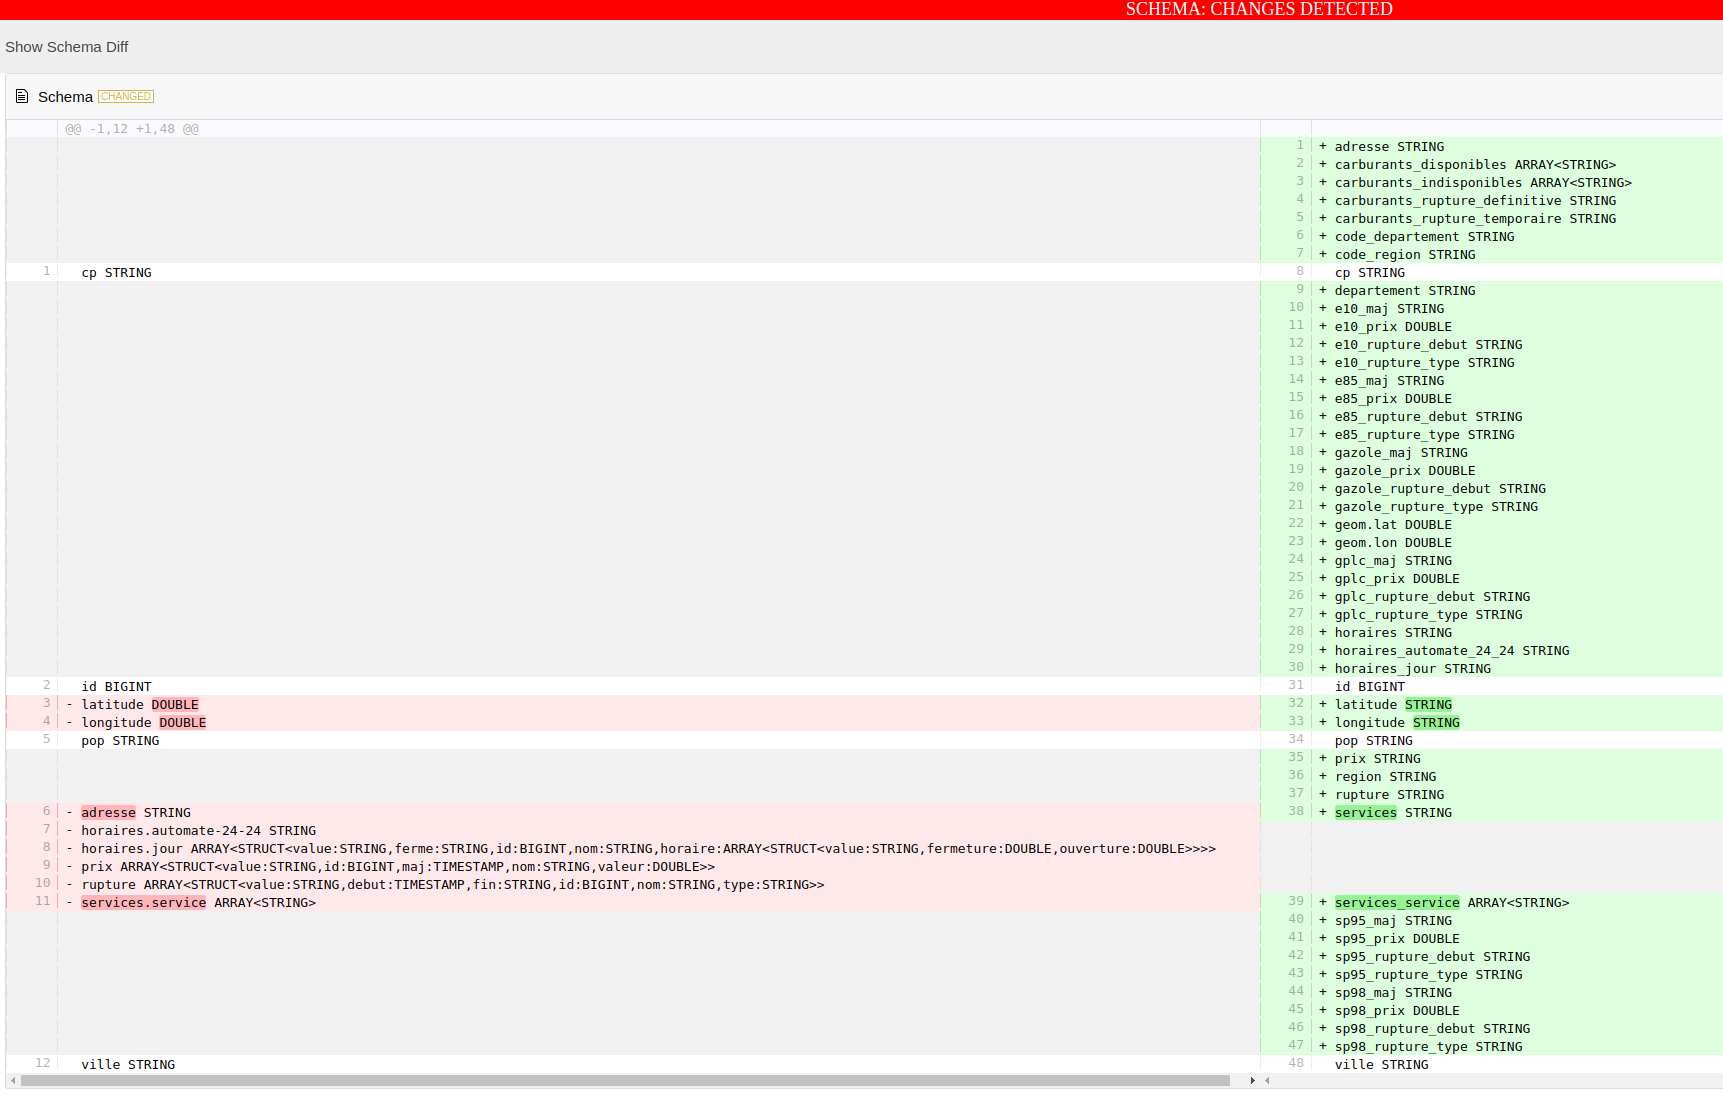


We see now in the schema diff that more column names match, but there are still many columns that only exist in the v2, like for instance `e10_prix`, `e10_maj`, `sp95_prix` and `sp95_maj`, which give the price and update time of that price for the E10 and SP95 gas types.
This is because the values from the column `prix` in the v1, which is an array of struct, have been "pivoted" in the v2. While this make it easier for the users to access each value (especially when building dashboards) this also has the downside of being less generic: if they ever introduce a new type of gas, they will have to alter the schema of the v2, while the v1 could have stored this new data without requiring any schema change.

*note: "SP95" means Sans-Plomb 95 which is unleaded 95 in English.*

# Phase 3: Computing the fields missing from v1

We will now update the v1 xml dataframe to add the columns that can be computed from other columns, such as `e10_prix` and `e10_maj`, etc.

In [97]:
carburants = ["E10", "E85", "SP95", "SP98", "Gazole", "GPLc"]
carburants_array = f.array([f.lit(c) for c in carburants])


def get_from(col_name, name):
    """Iterate over the array column `col_name` and only keep the records matching this name"""
    return f.filter(f.col(col_name), lambda c: c["nom"] == f.lit(name))


def clean_rupture_type(gas_type):
    res = f.array_max(get_from("rupture", gas_type)["type"])
    res = f.when(res != f.lit(""), res)
    return res


df_v1_xml_3 = df_v1_xml_2.withColumnsRenamed({
    "cp": "code postal",
}).withColumns({
    "services proposes": "services.service",
    "carburants disponibles": f.col("prix.nom"),
    "carburants indisponibles":
        f.nullif(
            f.filter(carburants_array, lambda c: ~f.array_contains(f.col("prix.nom"), c)),
            f.array()
        ),
    "e10_maj": get_from("prix", "E10")[0]["maj"],
    "e85_maj": get_from("prix", "E85")[0]["maj"],
    "sp95_maj": get_from("prix", "SP95")[0]["maj"],
    "sp98_maj": get_from("prix", "SP98")[0]["maj"],
    "gazole_maj": get_from("prix", "Gazole")[0]["maj"],
    "gplc_maj": get_from("prix", "GPLc")[0]["maj"],

    "e10_prix": get_from("prix", "E10")[0]["valeur"],
    "e85_prix": get_from("prix", "E85")[0]["valeur"],
    "sp95_prix": get_from("prix", "SP95")[0]["valeur"],
    "sp98_prix": get_from("prix", "SP98")[0]["valeur"],
    "gazole_prix": get_from("prix", "Gazole")[0]["valeur"],
    "gplc_prix": get_from("prix", "GPLc")[0]["valeur"],

    "e10_rupture_debut": f.array_max(get_from("rupture", "E10")["debut"]),
    "e85_rupture_debut": f.array_max(get_from("rupture", "E85")["debut"]),
    "sp95_rupture_debut": f.array_max(get_from("rupture", "SP95")["debut"]),
    "sp98_rupture_debut": f.array_max(get_from("rupture", "SP98")["debut"]),
    "gazole_rupture_debut": f.array_max(get_from("rupture", "Gazole")["debut"]),
    "gplc_rupture_debut": f.array_max(get_from("rupture", "GPLc")["debut"]),

    "e10_rupture_type": clean_rupture_type("E10"),
    "e85_rupture_type": clean_rupture_type("E85"),
    "sp95_rupture_type": clean_rupture_type("SP95"),
    "sp98_rupture_type": clean_rupture_type("SP98"),
    "gazole_rupture_type": clean_rupture_type("Gazole"),
    "gplc_rupture_type": clean_rupture_type("GPLc"),

    "horaires": f.col("horaires").dropFields("`automate-24-24`"),

    "code_departement": f.substring(f.col("code postal"), 0, 2),

    "automate 24-24 (oui/non)":
        f.when(f.col("horaires.automate-24-24") == f.lit(1), f.lit("Oui")).otherwise(f.lit("Non"))
})

We also update the v2 json to rename some column and have them match with v1.

In [98]:
df_v2_json_v2 = df_v2_json_raw.withColumnsRenamed({
    "cp": "code postal",
    "carburants_disponibles": "carburants disponibles",
    "carburants_indisponibles": "carburants indisponibles",
    "horaires_automate_24_24": "automate 24-24 (oui/non)",
    "services_service": "services proposes"
})

In [99]:
# We first sort the columns of each DataFrames to make the diff look better
df_v1 = df_v1_xml_3.select(*sorted(df_v1_xml_3.columns))
df_v2 = df_v2_json_v2.select(*sorted(df_v2_json_v2.columns))
diff_result = compare_dataframes(df_v1, df_v2, join_cols=["id"])
diff_result.export_to_html(
    title="Comparaison des sources: v1 vs v2 - Phase 3",
    diff_format_options=diff_format_options,
    output_file_path="diff_3.html"
)


Analyzing differences...
Generating the diff by joining the DataFrames together using the provided column: id
Report exported as diff_3.html


We now get the following schema diff:

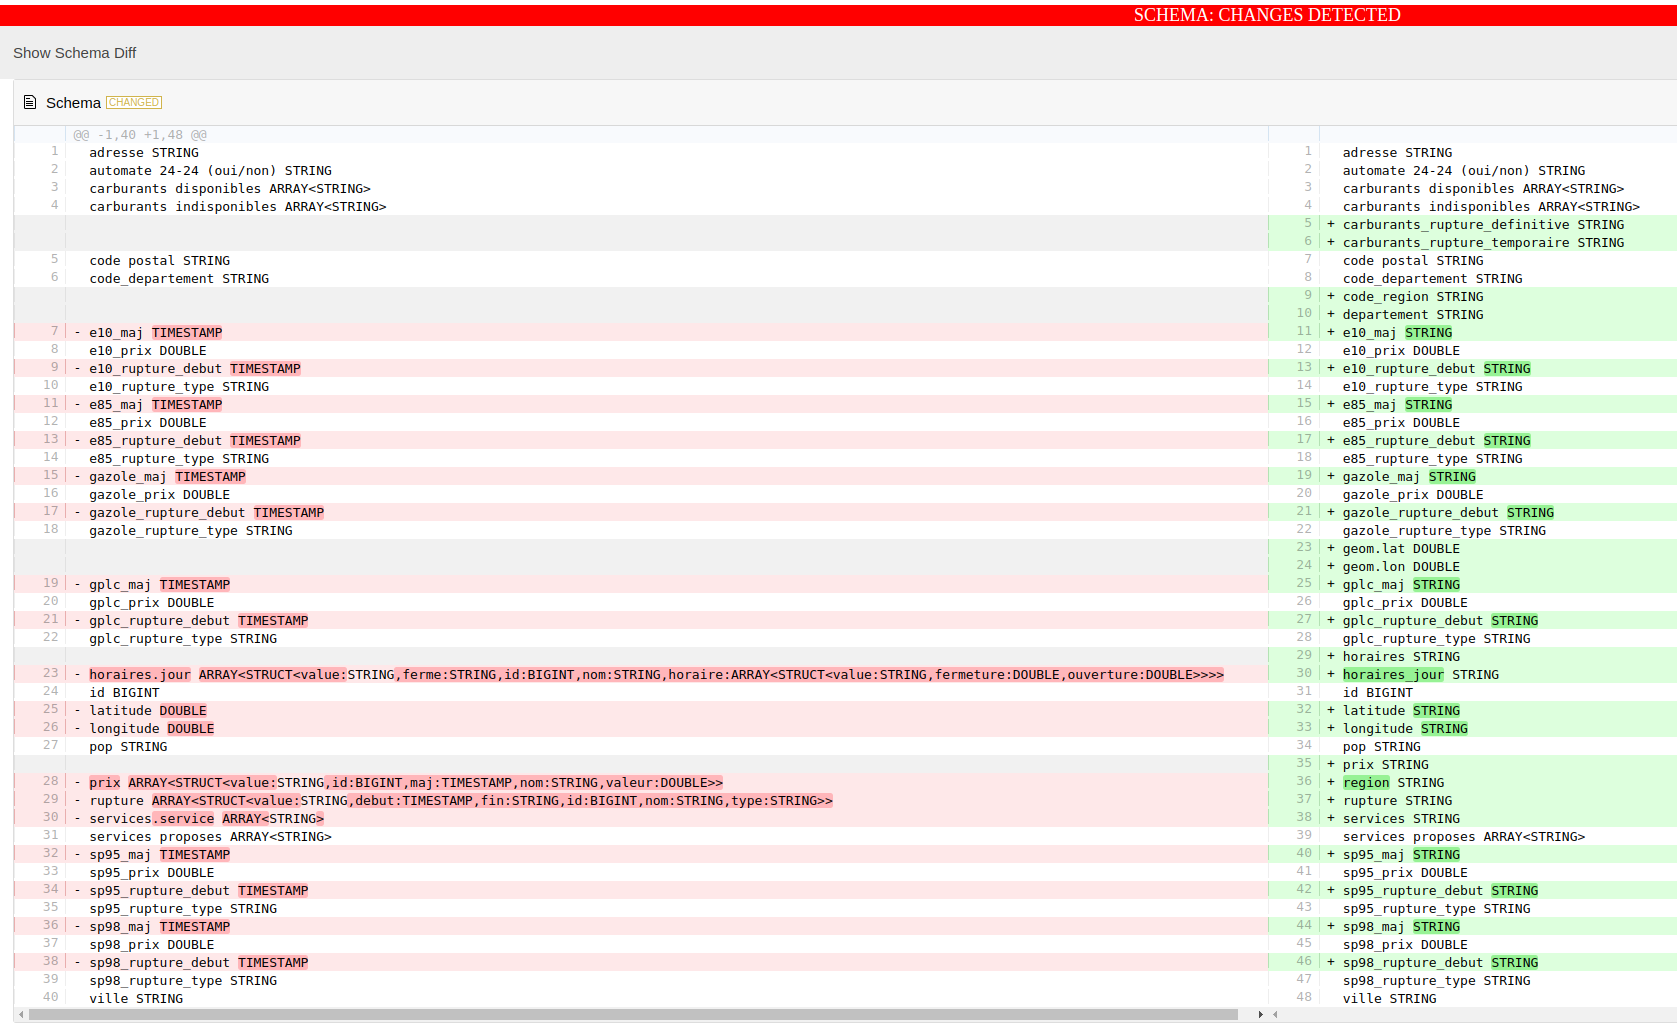

As we can see, things start to look better, but the types of many columns don't match. Despite that, the diff still compared columns that did not match, and we can see for example if we scroll down and click on the bar chart for the `sp_95` column, we see a breakdown of the most frequent changes happening, and we can see that the v2 timestamps strings are formatted with a timezone while the v1 was in UTC.

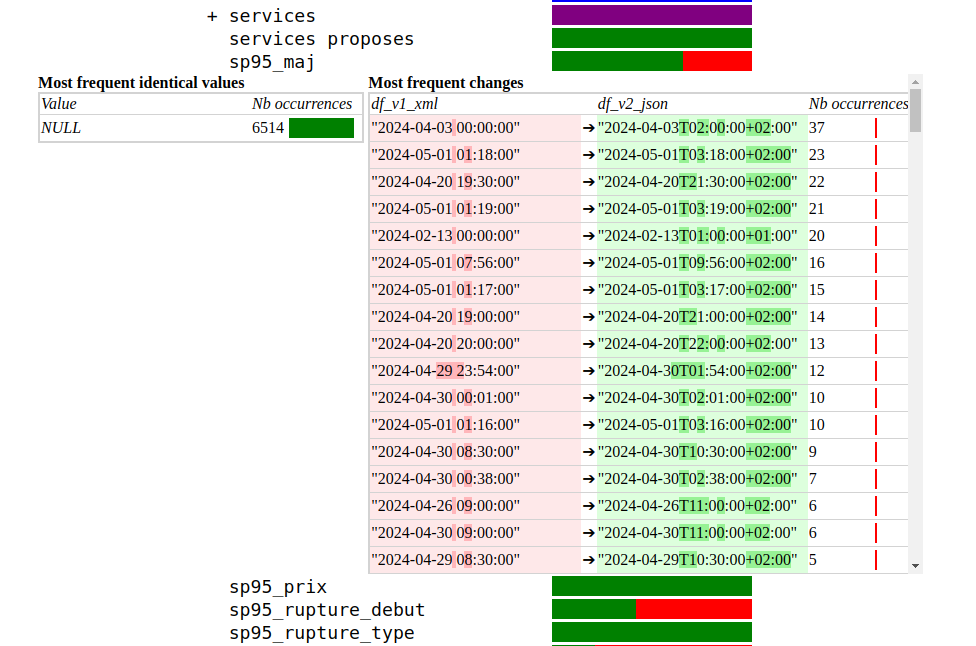

*Note: in the bar chart for each columns, the colors have the following meaning:*
- *green: values are identical in both DataFrames*
- *red: values are different between both DataFrames*
- *blue: exists only in v1*
- *purple: exists only in v2*

# Phase 4: Fixing types in the v2

We will now adapt the v2 to make it's types match the v1, as timestamp and double types are certainly better than strings.

In [100]:
df_v2_json_v3 = df_v2_json_v2.withColumns({
    "e10_maj": f.col("e10_maj").cast("timestamp"),
    "e85_maj": f.col("e85_maj").cast("timestamp"),
    "sp95_maj": f.col("sp95_maj").cast("timestamp"),
    "sp98_maj": f.col("sp98_maj").cast("timestamp"),
    "gazole_maj": f.col("gazole_maj").cast("timestamp"),
    "gplc_maj": f.col("gplc_maj").cast("timestamp"),
    "e10_prix": f.col("e10_prix").cast("double"),
    "e85_prix": f.col("e85_prix").cast("double"),
    "sp95_prix": f.col("sp95_prix").cast("double"),
    "sp98_prix": f.col("sp98_prix").cast("double"),
    "gazole_prix": f.col("gazole_prix").cast("double"),
    "gplc_prix": f.col("gplc_prix").cast("double"),
    "latitude": f.col("latitude").cast("double"),
    "longitude": f.col("longitude").cast("double"),
})


def to_utc_timestamp(ts: Column) -> Column:
    return f.to_timestamp(ts)


df_v2_json_v4 = df_v2_json_v3.withColumns({
    "e10_maj": to_utc_timestamp(f.col("e10_maj")),
    "e10_rupture_debut": to_utc_timestamp(f.col("e10_rupture_debut")),
    "e85_maj": to_utc_timestamp(f.col("e85_maj")),
    "e85_rupture_debut": to_utc_timestamp(f.col("e85_rupture_debut")),
    "gazole_maj": to_utc_timestamp(f.col("gazole_maj")),
    "gazole_rupture_debut": to_utc_timestamp(f.col("gazole_rupture_debut")),
    "gplc_maj": to_utc_timestamp(f.col("gplc_maj")),
    "gplc_rupture_debut": to_utc_timestamp(f.col("gplc_rupture_debut")),
    "sp95_maj": to_utc_timestamp(f.col("sp95_maj")),
    "sp95_rupture_debut": to_utc_timestamp(f.col("sp95_rupture_debut")),
    "sp98_maj": to_utc_timestamp(f.col("sp98_maj")),
    "sp98_rupture_debut": to_utc_timestamp(f.col("sp98_rupture_debut")),
})

In [101]:
# We first sort the columns of each DataFrames to make the diff look better
df_v1 = df_v1_xml_3.select(*sorted(df_v1_xml_3.columns))
df_v2 = df_v2_json_v4.select(*sorted(df_v2_json_v4.columns))
diff_result = compare_dataframes(df_v1, df_v2, join_cols=["id"])
diff_result.export_to_html(
    title="Comparaison des sources: v1 vs v2 - Phase 4",
    diff_format_options=diff_format_options,
    output_file_path="diff_4.html"
)


Analyzing differences...
Generating the diff by joining the DataFrames together using the provided column: id
Report exported as diff_4.html


The schema diff looks even better now:

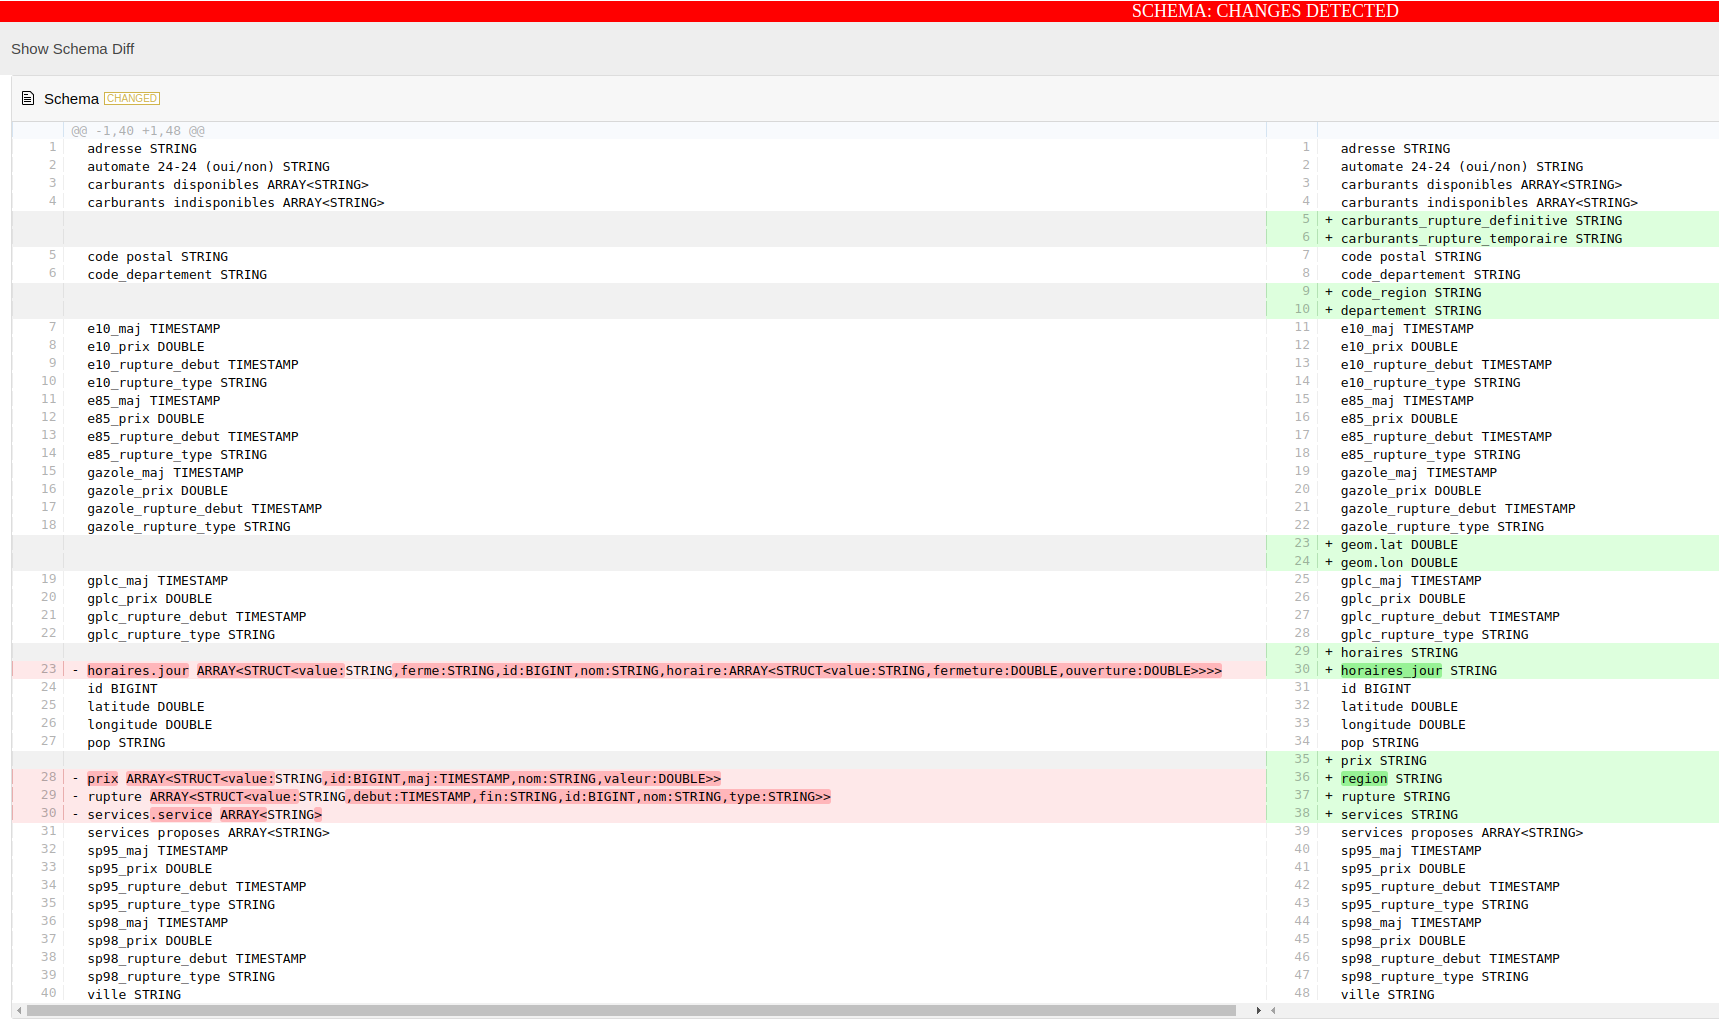

And so does the data diff, for most columns anyway:

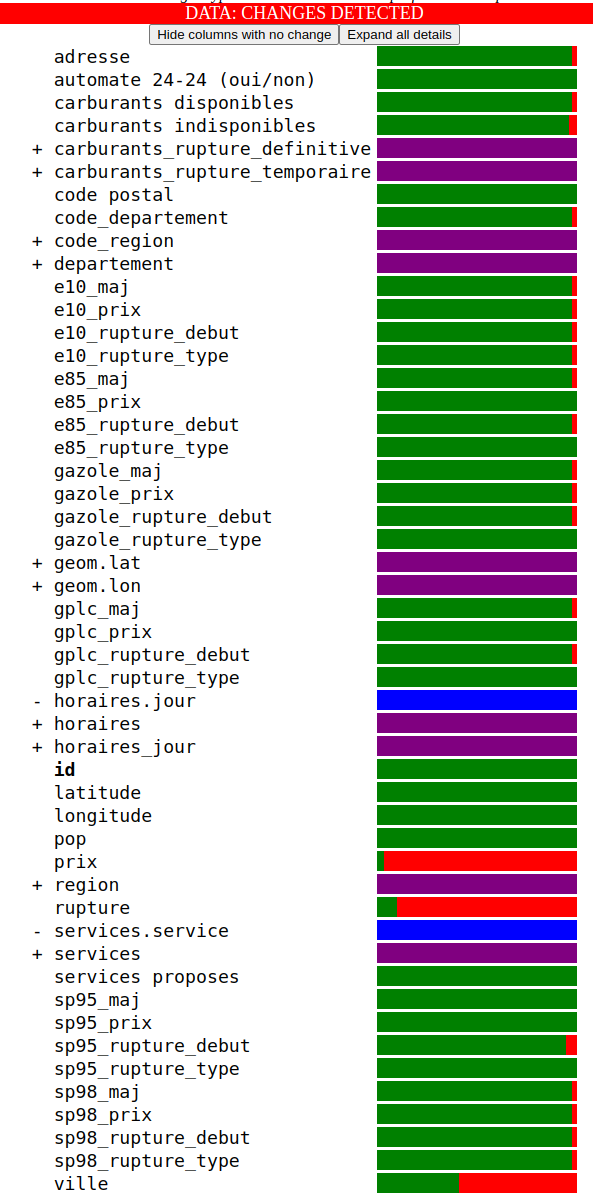

We still see major differences for the columns `prix` and `rupture`, though.
As we can see in the schema, this is because they are arrays of struct in the v1 and simple strings in the v2.

By clicking on the bar chart for the `prix` column, we can see that the string value in the v2 is a JSON that is sometimes an `ARRAY<STRUCT>` and sometimes a `STRUCT`.

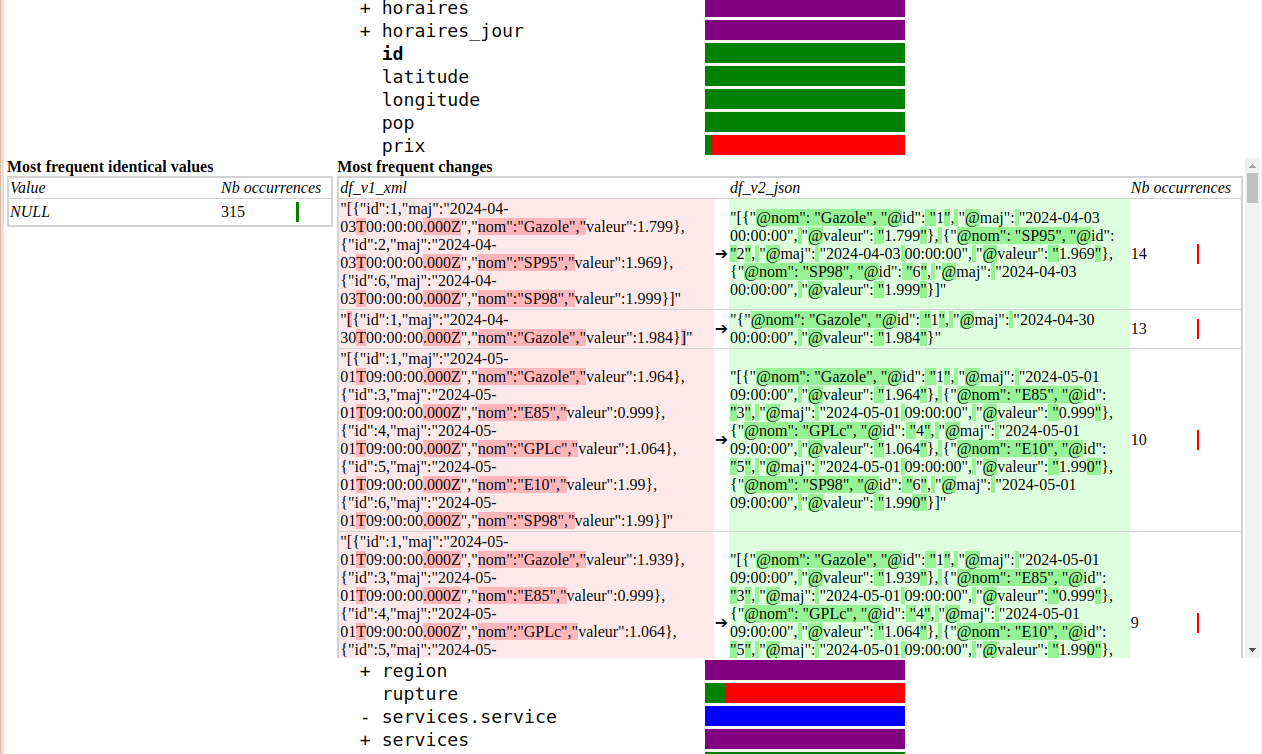

# Phase 5: Parsing the json columns from v2

We will now parse the columns in the v2 that are json strings to make them match the types from v1.

In [102]:
from spark_frame.transformations import parse_json_columns

df_v2_json_v5 = df_v2_json_v4.transform(parse_json_columns, "horaires")
# or equivalently
# df_v2_json_v5 = parse_json_columns(df_v2_json_v4, "horaires")

## [Parenthesis] Introducing a feature: parse_json_columns

You are probably already familiar with Spark's built-in function [`from_json`](https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.sql.functions.from_json.html), which can be used to parse a json string column into a SQL type. But this function requires to specify the target schema in advance and we are lazy. So instead, we use the [`spark_frame.transformations.parse_json_columns`](https://furcypin.github.io/spark-frame/reference/transformations/#spark_frame.transformations_impl.parse_json_columns.parse_json_columns) that will automatically run a first pass to autodetect the schema and then pass it to the `from_json` method.

When using it, be aware however that this require to process the DataFrame a first time to infer the schema, and also that it requires a `rdd.map` step that will require to execute Python on the executor's side, so it is not optimal in terms of performance, but it's okay for small datasets.

*By the way if someone knows a way to convert a `DataFrame` into an `RDD[String]` in  PyPsark without needing a `rdd.map` step, I'm interested.*

In [103]:
df_v2_json_v5.select("horaires").printSchema()

root
 |-- horaires: struct (nullable = true)
 |    |-- @automate-24-24: string (nullable = true)
 |    |-- jour: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- @ferme: string (nullable = true)
 |    |    |    |-- @id: string (nullable = true)
 |    |    |    |-- @nom: string (nullable = true)
 |    |    |    |-- horaire: string (nullable = true)




## [Parenthesis] Introducing a feature: nested.print_schema

---


As you can see, the type of the `horaires` column is heavily nested.
Understanding it's structure and reading the full names of it's field can be somewhat difficult for the human eye.

**For instance, the full path of the field `@id` is `horaires.jour!.@id`.**

This name `horaires.jour!.@id` is hard to spot when reading the output of `printSchema()`, as it require to eye over several lines of text to extract non-aligned information from it. And of course if gets even worse when the level of nesting goes even deeper.

*Note that we added exclamation mark at the end of the name of the field `jour. This is a convention that makes repeated fields easier to spot.*

Therefore, we made a method that prints a flat version of the DataFrame's schema, like this:


In [104]:
from spark_frame import nested

nested.print_schema(df_v2_json_v5.select("horaires"))

root
 |-- horaires.@automate-24-24: string (nullable = true)
 |-- horaires.jour!.@ferme: string (nullable = true)
 |-- horaires.jour!.@id: string (nullable = true)
 |-- horaires.jour!.@nom: string (nullable = true)
 |-- horaires.jour!.horaire: string (nullable = true)



As you can see, the output schema is more compact but also more readable.
Additionnaly, this naming convention will be useful for the next transformation.

Indeed, the field `horaires.jour!.horaire` is itself a string containing a json value that we need to parse (again).

In [105]:
from spark_frame import nested

df_v2_json_v6 = df_v2_json_v5.transform(nested.with_fields, {
    "horaires.jour!.horaire": lambda jour:
    f.coalesce(
        f.from_json(jour["horaire"], "ARRAY<STRUCT<`@fermeture`: STRING, `@ouverture`: STRING>>"),
        f.array(
            f.from_json(jour["horaire"], "STRUCT<`@fermeture`: STRING, `@ouverture`: STRING>"),
        ),
    )
})

## [Parenthesis] Introducing a feature: nested.with_fields

Here we used another powerful method from spark_frame: [`nested.with_fields`](https://furcypin.github.io/spark-frame/reference/nested/#spark_frame.nested_impl.with_fields.with_fields). This method is the equivalent of (`DataFrame.withColumn`)[https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.withColumns.html] except it also works with fields nested inside arrays.

Therefore, we can apply transformation to the elements of the array `horaires.jour`, which will apply the transformation to the right fields without affecting the other fields.

In [106]:
nested.print_schema(df_v2_json_v6.select("horaires"))

root
 |-- horaires.@automate-24-24: string (nullable = true)
 |-- horaires.jour!.@ferme: string (nullable = true)
 |-- horaires.jour!.@id: string (nullable = true)
 |-- horaires.jour!.@nom: string (nullable = true)
 |-- horaires.jour!.horaire!.@fermeture: string (nullable = true)
 |-- horaires.jour!.horaire!.@ouverture: string (nullable = true)



Next, we continue parsing the other json columns from v2:

In [107]:
df_v2_json_v7 = df_v2_json_v6.withColumns({
    "prix":
        f.coalesce(
            f.from_json("prix", "ARRAY<STRUCT<`@id`: STRING, `@maj`: TIMESTAMP, `@nom`: STRING, `@valeur`: STRING>>"),
            f.array(
                f.from_json("prix", "STRUCT<`@id`: STRING, `@maj`: TIMESTAMP, `@nom`: STRING, `@valeur`: STRING>")
            ),
        ),
    "rupture":
        f.from_json("rupture", "ARRAY<STRUCT<`@debut`:STRING,`@fin`:STRING,`@id`:STRING,`@nom`:STRING,`@type`:STRING>>"),
})

We drop the "@" at the beginning of field names to match with names from the v1:

In [108]:
def clean_field_names(name: str):
    name = name.lower()
    if name.startswith("@") :
        return name[1:]
    else:
        return name

df_v2_json_v8 = df_v2_json_v7.transform(
    transform_all_field_names, clean_field_names
).transform(nested.with_fields, {
    "horaires": lambda df: df["horaires"].dropFields("`automate-24-24`"),
}).drop("services", "horaires_jour")

And we also drop unecessary fields from v1:

In [109]:
df_v1_xml_4 = df_v1_xml_3.transform(nested.with_fields, {
    "horaires.jour!": lambda jour: jour.dropFields("value"),
    "prix!": lambda prix: prix.dropFields("value"),
    "rupture!": lambda rupture: rupture.dropFields("value"),
}).transform(nested.with_fields, {
    "horaires.jour!.horaire!": lambda horaire: horaire.dropFields("value"),
}).drop(
    "services"
)

In [110]:
# We first sort the columns of each DataFrames to make the diff look better
df_v1 = df_v1_xml_4.select(*sorted(df_v1_xml_4.columns))
df_v2 = df_v2_json_v8.select(*sorted(df_v2_json_v8.columns))
diff_result = compare_dataframes(df_v1, df_v2, join_cols=["id"])
diff_result.export_to_html(
    title="Comparaison des sources: v1 vs v2 - Phase 5",
    diff_format_options=diff_format_options,
    output_file_path="diff_5.html"
)


Analyzing differences...
Generating the diff by joining the DataFrames together using the provided column: id
Report exported as diff_5.html


In this new report, when see that the column `horaires.jour` still has many differences, but when we click on it to view the comparison details, they are not very easy to interpret. Luckily, as we will see in the next phase, this can be improved.

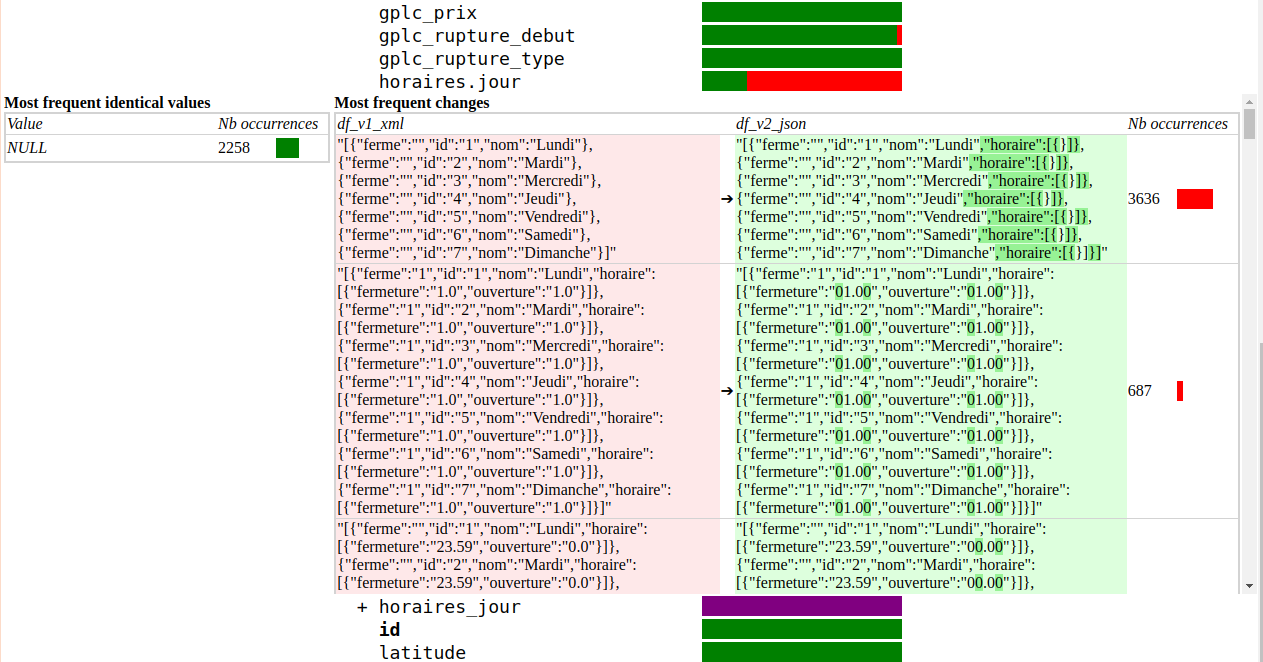

# Phase 6: Better diff between nested columns

We can make the diff more precise on nested columns if we specify the field to use as "id" to compare arrays of structs. In our example we notice that the DataFrame have fields `prix!.id` and `horaires.jour!.id` which can uniquely identify elements of their respective arrays.

Therefore we will use these field to improve the join_cols parameter passed to the `compare_dataframes` method.


In [111]:
diff_result = compare_dataframes(df_v1, df_v2, join_cols=["id", "prix!.id", "horaires.jour!.id"])
diff_result.export_to_html(
    title="Comparaison des sources: v1 vs v2 - Phase 6",
    diff_format_options=diff_format_options,
    output_file_path="diff_6.html"
)


Analyzing differences...
Generating the diff by joining the DataFrames together using the provided column: id
Generating the diff by joining the DataFrames together using the provided columns: ['id', 'horaires.jour!.id']
Generating the diff by joining the DataFrames together using the provided columns: ['id', 'prix!.id']
Report exported as diff_6.html


*Note: The diff takes a little longer now, because it has to expand the DataFrames against several dimensions, but please bear in mind that this Colab has not many resources and that it would run much faster on a real cluster.*

*As a comparison, on my 8-core laptop, it generally runs in around 50 seconds.*


In this new report, we can now see the `horaires.jour!` array being expanded and see the diff on each of it's subfield. This is because we told the program to use `"horaires.jour!.id"` in its `join_cols`. We can now clearly see that the differences on the field `horaires.jour!.horaire` are mostly caused by the fact that the types are different and because of some NULL values being incorrectly parsed. We will fix this in the final phase.

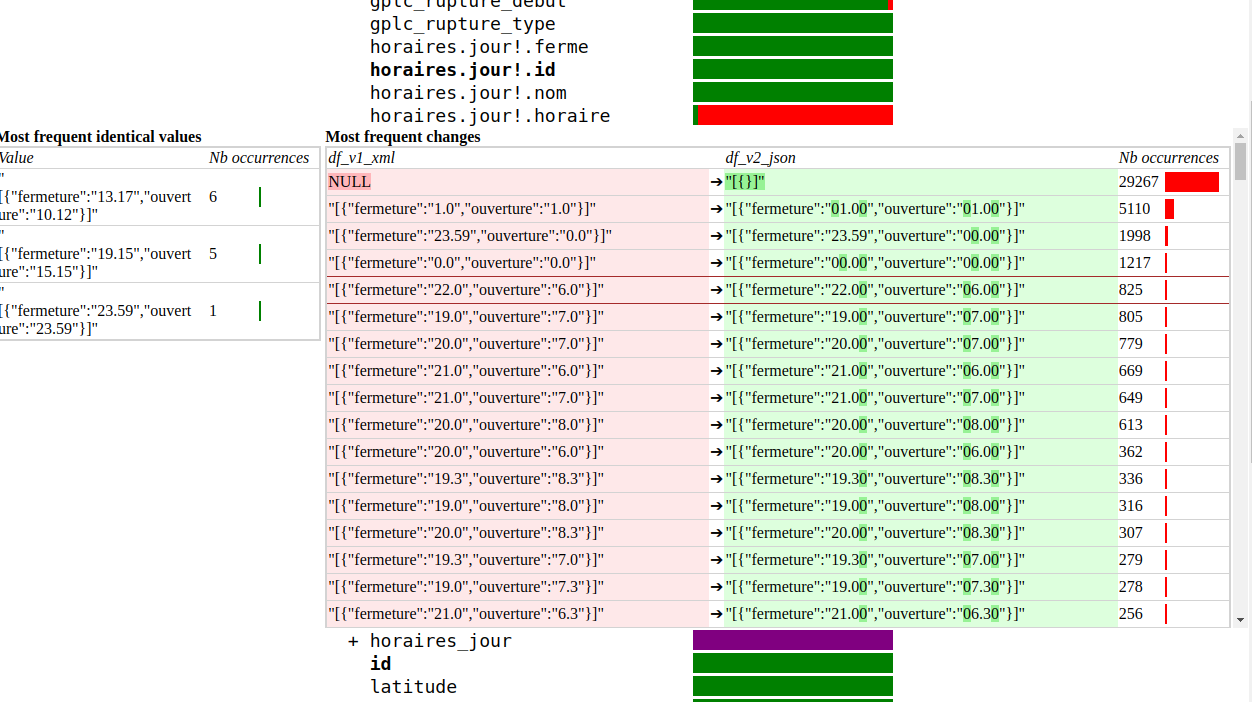

# Phase 7: Last fixes

In [112]:
df_v2_json_v9 = df_v2_json_v8.transform(nested.with_fields, {
    "prix!.id": lambda prix: prix["id"].cast("BIGINT"),
    "prix!.valeur": lambda prix: prix["valeur"].cast("DOUBLE"),
    "rupture!.debut": lambda rupture: rupture["debut"].cast("TIMESTAMP"),
    "rupture!.id": lambda rupture: rupture["id"].cast("BIGINT"),
    "horaires.jour!.id": lambda jour: jour["id"].cast("BIGINT"),
    "horaires.jour!.horaire!.ouverture": lambda horaire: horaire["ouverture"].cast("DOUBLE"),
    "horaires.jour!.horaire!.fermeture": lambda horaire: horaire["fermeture"].cast("DOUBLE"),
}).transform(nested.with_fields, {
    "horaires.jour!.horaire": lambda jour:
        f.when(
            (f.array_size(jour["horaire"]) == f.lit(1))
            & jour["horaire"][0]["fermeture"].isNull()
            & jour["horaire"][0]["ouverture"].isNull(), f.lit(None)
        ).otherwise(
            jour["horaire"]
        )
})

In [113]:
df_v1 = df_v1_xml_4.select(*sorted(df_v1_xml_4.columns))
df_v2 = df_v2_json_v9.select(*sorted(df_v2_json_v9.columns))
diff_result = compare_dataframes(df_v1, df_v2, join_cols=["id", "prix!.id", "horaires.jour!.id"])
diff_result.export_to_html(
    title="Comparaison des sources: v1 vs v2 - Phase 7",
    diff_format_options=diff_format_options,
    output_file_path="diff_7.html"
)


Analyzing differences...
Generating the diff by joining the DataFrames together using the provided column: id
Generating the diff by joining the DataFrames together using the provided columns: ['id', 'horaires.jour!.id']
Generating the diff by joining the DataFrames together using the provided columns: ['id', 'prix!.id']
Report exported as diff_7.html
